In [16]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
#from torch.nn.utils import clip_grad_norm_
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [17]:
experiment       = 'synth1'
abduction        = False
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [18]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
n_varsll = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
n_varshl = len(Ghl.nodes())


omega    = mut.load_omega_map(experiment)

In [19]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [20]:
# # [Not suggested] In case we want to explore also the interventional --> worse estimation!
# Dlls, Dhls = [], []
# for dpair in list(mut.load_samples(experiment).values()):
#     Dlls.append(dpair[0])
#     Dhls.append(dpair[1])
    
# ll_coeffs = mut.get_coefficients(Dlls, Gll)
# hl_coeffs = mut.get_coefficients(Dhls, Ghl) 

In [21]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [22]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [23]:
def create_psd_matrix(size):
    A = torch.randn(size, size).float()

    return torch.matmul(A, A.T)

# PCA Projection from higher to lower dimension
def pca_projection(Sigma, target_dim):
    """
    Project a d×d matrix to a k×k matrix where k < d
    Args:
        Sigma: source matrix (d×d)
        target_dim: target dimension k
    Returns:
        k×k projected matrix
    """
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = torch.linalg.eigh(Sigma)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Take only the top target_dim eigenvectors
    V = eigenvectors[:, :target_dim]  # d×k matrix
    
    # Project the covariance matrix
    Sigma_projected = torch.matmul(torch.matmul(V.T, Sigma), V)  # k×k matrix
    
    return Sigma_projected, V

# SVD Projection from higher to lower dimension
def svd_projection(Sigma, target_dim):
    """
    Project a d×d matrix to a k×k matrix where k < d using SVD
    Args:
        Sigma: source matrix (d×d)
        target_dim: target dimension k
    Returns:
        k×k projected matrix
    """
    # Perform SVD
    U, S, V = torch.svd(Sigma)
    
    # Take only the first target_dim components
    U_k = U[:, :target_dim]  # d×k matrix
    S_k = S[:target_dim]     # k singular values
    
    # Project the covariance matrix
    Sigma_projected = torch.matmul(torch.matmul(U_k.T, Sigma), U_k)  # k×k matrix
    
    return Sigma_projected, U_k

def project_covariance(Sigma, n, method):
    if method == 'pca':
        return pca_projection(Sigma, n)
    elif method == 'svd':
        return svd_projection(Sigma, n)
    else:
        raise ValueError(f"Unknown projection method: {method}")
    
def compute_struc_matrices(models, I):
    matrices = []
    for iota in I:
        M_i = torch.from_numpy(models[iota]._compute_reduced_form()).float()  
        matrices.append(M_i)

    return matrices

def compute_mu_bary(struc_matrices, mu):
    struc_matrices_tensor = torch.stack(struc_matrices)
    mu_barycenter         = torch.sum(struc_matrices_tensor @ mu, dim=0) / len(struc_matrices)

    return mu_barycenter

def compute_Sigma_bary(matrices, Sigma, initialization, max_iter, tol):

    Sigma_matrices = []
    for M in matrices:
        Sigma_matrices.append(M @ Sigma @ M.T)

    return covariance_bary_optim(Sigma_matrices, initialization, max_iter, tol)

def covariance_bary_optim(Sigma_list, initialization, max_iter, tol):
    
    if initialization == 'psd':
        S_0 = create_psd_matrix(Sigma_list[0].shape[0])
    elif initialization == 'avg':
        S_0 = sum(Sigma_list) / len(Sigma_list)
    
    S_n = S_0.clone()
    n   = len(Sigma_list)  # Number of matrices
    lambda_j = 1.0 / n   # Equal weights
    
    for n in range(max_iter):
        S_n_old = S_n.clone()

        S_n_inv_half = oput.sqrtm_svd(regmat(torch.inverse(S_n)))
        
        # Compute the sum of S_n^(1/2) Σ_j S_n^(1/2)
        sum_term = torch.zeros_like(S_n)
        for Sigma_j in Sigma_list:
            S_n_half   = oput.sqrtm_svd(regmat(S_n))
            inner_term = torch.matmul(torch.matmul(S_n_half, Sigma_j), S_n_half)
            sqrt_term  = oput.sqrtm_svd(regmat(inner_term))
            sum_term  += lambda_j * sqrt_term
        # Square the sum term
        squared_sum = torch.matmul(sum_term, sum_term.T)

        S_n_next = torch.matmul(torch.matmul(S_n_inv_half, squared_sum), S_n_inv_half)
        S_n = S_n_next

        if torch.norm(S_n - S_n_old, p='fro') < tol:
            #print(f"Converged after {n+1} iterations")
            break
            
    return S_n

def monge(m1, S1, m2, S2):
    inner      = torch.matmul(oput.sqrtm_svd(S1), torch.matmul(S2, oput.sqrtm_svd(S1)))
    sqrt_inner = oput.sqrtm_svd(inner)
    A          = torch.matmul(torch.inverse(oput.sqrtm_svd(regmat(S1))), torch.matmul(sqrt_inner, torch.inverse(oput.sqrtm_svd(regmat(S1)))))  

    # Define the Monge map as a function τ(x) = m_2 + A(x - m_1)
    def tau(x):
        return m2 + A @ (x - m1)

    return tau, A

def regmat(matrix, eps=1e-10):
    # Replace NaN and Inf values with finite numbers
    matrix = torch.nan_to_num(matrix, nan=0.0, posinf=1e10, neginf=-1e10)
    
    # Add a small epsilon to the diagonal for numerical stability
    if matrix.dim() == 2 and matrix.size(0) == matrix.size(1):
        matrix = matrix + eps * torch.eye(matrix.size(0), device=matrix.device)
    
    return matrix


In [24]:
def auto_bary_optim(theta_baryL, theta_baryH, max_iter, tol, seed):

    # Set seeds for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    mu_L, Sigma_L = torch.from_numpy(theta_baryL['mu_U']).float(), torch.from_numpy(theta_baryL['Sigma_U']).float()
    mu_H, Sigma_H = torch.from_numpy(theta_baryH['mu_U']).float(), torch.from_numpy(theta_baryH['Sigma_U']).float()


    T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)

    optimizer_T        = torch.optim.Adam([T], lr=0.001)
    previous_objective = float('inf')
    objective_T        = 0  # Reset objective at the start of each step
    # Optimization loop
    for step in range(max_iter):
        objective_T = 0  # Reset objective at the start of each step

        # Calculate each term of the Wasserstein distance
        term1 = torch.norm(T @ mu_L - mu_H) ** 2  # Squared Euclidean distance between transformed means
        term2 = torch.trace(T @ Sigma_L @ T.T)   # Trace term for low-level covariance
        term3 = torch.trace(Sigma_H)             # Trace term for high-level covariance
        
        # Compute the intermediate covariance matrices
        T_Sigma_L_T      = torch.matmul(T, torch.matmul(Sigma_L, T.T))
        T_Sigma_L_T_sqrt = oput.sqrtm_svd(T_Sigma_L_T)
        Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)
        
        # Coupling term using nuclear norm
        term4 = -2 * torch.norm(T_Sigma_L_T_sqrt @ Sigma_H_sqrt, p='nuc')

        # Total objective is the sum of terms
        objective_T += term1 + term2 + term3 + term4

        if abs(previous_objective - objective_T.item()) < tol:
            print(f"Converged at step {step + 1}/{max_iter} with objective: {objective_T.item()}")
            break

        # Update previous objective
        previous_objective = objective_T.item()

        # Perform optimization step
        optimizer_T.zero_grad()  # Clear gradients
        objective_T.backward(retain_graph=True)  # Backpropagate
        optimizer_T.step()  # Update T

    return T  # Return final objective and optimized T

In [25]:
def barycentric_optimization(theta_L, theta_H, LLmodels, HLmodels, Ill, Ihl, projection_method, initialization, autograd, seed, max_iter, tol, display_results):

    # Start timing
    start_time = time.time()

    mu_L, Sigma_L = torch.from_numpy(theta_L['mu_U']).float(), torch.from_numpy(theta_L['Sigma_U']).float()
    mu_H, Sigma_H = torch.from_numpy(theta_H['mu_U']).float(), torch.from_numpy(theta_H['Sigma_U']).float()

    h, l = mu_H.shape[0], mu_L.shape[0]

    # Initialize the structural matrices    
    L_matrices = compute_struc_matrices(LLmodels, Ill)
    H_matrices = compute_struc_matrices(HLmodels, Ihl)

    # Initilize the barycenteric means and covariances
    mu_bary_L = compute_mu_bary(L_matrices, mu_L)
    mu_bary_H = compute_mu_bary(H_matrices, mu_H)

    Sigma_bary_L = compute_Sigma_bary(L_matrices, Sigma_L, initialization, max_iter, tol)
    Sigma_bary_H = compute_Sigma_bary(H_matrices, Sigma_H, initialization, max_iter, tol)
    
    proj_Sigma_bary_L, Tp = project_covariance(Sigma_bary_L, h, projection_method)
    proj_mu_bary_L        = torch.matmul(Tp.T, mu_bary_L)

    paramsL = {'mu_U': mu_bary_L.detach().numpy(), 'Sigma_U': Sigma_bary_L.detach().numpy(), 'radius': epsilon}
    paramsH = {'mu_U': mu_bary_H.detach().numpy(), 'Sigma_U': Sigma_bary_H.detach().numpy(), 'radius': delta}

    if autograd == True:
        params_bary_autograd = {
                                'theta_baryL': paramsL,
                                'theta_baryH': paramsH,
                                'max_iter': 10,
                                'tol': 1e-5,
                                'seed': seed
                               }
        
        T = auto_bary_optim(**params_bary_autograd)

    else:
        tau, A = monge(proj_mu_bary_L, proj_Sigma_bary_L, mu_bary_H, Sigma_bary_H)
        T = torch.matmul(A, Tp.T)

    T  = T.detach().numpy()
    Tp = Tp.detach().numpy()

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Display results
    if display_results == True: 
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T

In [26]:
def check_for_invalid_values(matrix):
    if torch.isnan(matrix).any() or torch.isinf(matrix).any():
        #print("Matrix contains NaN or Inf values!")
        return True
    return False

def handle_nans(matrix, replacement_value=0.0):
    # Replace NaNs with a given value (default is 0)
    if torch.isnan(matrix).any():
        print("Warning: NaN values found! Replacing with zero.")
        matrix = torch.nan_to_num(matrix, nan=replacement_value)
    return matrix

In [27]:
def update_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta):
    term1     = torch.zeros_like(mu_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float() 
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float() 

        term1     = term1 + V_i.T @ V_i @ mu_L.float() - V_i.T @ H_i @ mu_H.float()
    
    term2     = 0 #-2 * lambda_L * (mu_L - hat_mu_L)
    grad_mu_L = (2 / (n+1)) * term1 - term2
    
    return mu_L + (eta * grad_mu_L)

def update_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta):

    term1     = torch.zeros_like(mu_H)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()  
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()  

        term1 = term1 + H_i.T @ H_i @ mu_H.float() - (V_i.T @ H_i).T @ mu_L.float()
    
    term2     = 0 #-2 * lambda_H * (mu_H - hat_mu_H)
    grad_mu_H = (2 / (n+1)) * term1 - term2

    return mu_H + (eta * grad_mu_H)


def update_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta):

    term1        = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
        V_i = T @ L_i.float()

        term1 = term1 + V_i.T @ V_i

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    term2        = 0 #-2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)
    grad_Sigma_L = (2 / (n+1)) * term1 - term2
    
    return Sigma_L + eta * grad_Sigma_L

def update_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta):

    term1        = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i   = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
        
        term1 = term1 + H_i.T @ H_i

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    term2        = 0 #-2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)
    grad_Sigma_H = (2 / (n+1)) * term1 - term2

    return Sigma_H + eta * grad_Sigma_H

def update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param):

    Sigma_L = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()  
        V_i = oput.regmat(T @ L_i)  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = V_i @ Sigma_L_half @ V_i.T
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V)) 

        norm_before = torch.norm(sqrtm_V_Sigma_V, p='fro')
        norm_after = torch.norm(oput.prox_operator(sqrtm_V_Sigma_V, lambda_param), p='fro')
        
        if norm_before - norm_after > 0:
            print('norm decrease at Sigma_L')
        else:
            print('norm INCREASE at Sigma_L')

        prox_Sigma_L_half = oput.prox_operator(sqrtm_V_Sigma_V, lambda_param) @ oput.prox_operator(sqrtm_V_Sigma_V, lambda_param).T
        
        #ll_term_a = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half)
        #ll_term_b = oput.regmat(torch.linalg.pinv(V_i).T)
        #ll_term   = ll_term_a @ ll_term_b
        ll_term   = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half) @ oput.regmat(torch.linalg.pinv(V_i).T)

        Sigma_H   = Sigma_H.float()  
        H_Sigma_H = H_i @ Sigma_H @ H_i.T

        hl_term   = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro') 

        Sigma_L = Sigma_L + (ll_term * hl_term)

    Sigma_L_final = (2 / (n+1)) * Sigma_L 
    Sigma_L_final = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

def update_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param):
    Sigma_H = torch.zeros_like(Sigma_H_half)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
        V_i = oput.regmat(T @ L_i.float())
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()

        #H_Sigma_H         = oput.regmat(H_i @ Sigma_H_half @ H_i.T)
        H_Sigma_H         = H_i @ Sigma_H_half @ H_i.T
        sqrtm_H_Sigma_H   = oput.regmat(oput.sqrtm_svd(H_Sigma_H)) 

        #sqrtm_H_Sigma_H   = oput.sqrtm_svd(H_Sigma_H) 
        norm_before = torch.norm(sqrtm_H_Sigma_H, p='fro')
        norm_after = torch.norm(oput.prox_operator(sqrtm_H_Sigma_H, lambda_param), p='fro')
        
        if norm_before - norm_after > 0:
            print('norm decrease at Sigma_H')
        else:
            print('norm INCREASE at Sigma_H')
        prox_Sigma_H_half = oput.prox_operator(sqrtm_H_Sigma_H, lambda_param) @ oput.prox_operator(sqrtm_H_Sigma_H, lambda_param).T
        #hl_term           = torch.inverse(H_i) @ prox_Sigma_H_half @ torch.inverse(H_i).T
        hl_term           = H_i @ prox_Sigma_H_half @ H_i.T
        
        V_Sigma_V = V_i @ Sigma_L @ V_i.T
        ll_term   = torch.norm(oput.sqrtm_svd(oput.regmat(V_Sigma_V)))

        Sigma_H = Sigma_H + (ll_term * hl_term)
    
    Sigma_H_final = (2 / (n+1)) * Sigma_H
    Sigma_H_final = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [28]:
def optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, lambda_L, lambda_H, lambda_param, eta, num_steps_max, epsilon, delta, seed):
    
    torch.manual_seed(seed)
    cur_T = T.clone()

    for t in range(num_steps_max): 
        objective_theta = 0
        # obj_values = []

        mu_L         = update_mu_L(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta)
        mu_H         = update_mu_H(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta)

        Sigma_L_half = update_Sigma_L_half(cur_T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta)
        Sigma_L      = update_Sigma_L(cur_T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param)
        
        Sigma_H_half = update_Sigma_H_half(cur_T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta)
        
        Sigma_H      = update_Sigma_H(cur_T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param)
        
        # Project onto Gelbrich balls
        mu_L, Sigma_L = oput.project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        mu_H, Sigma_H = oput.project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        # Verify constraints
        satisfied_L, dist_L, epsi = oput.verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        satisfied_H, dist_H, delt = oput.verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        if not satisfied_L:
            print(f"Warning: Constraints not satisfied for mu_L and Sigma_L! Distance: {dist_L} and epsilon = {epsi}")

        if not satisfied_H:
            print(f"Warning: Constraints not satisfied for mu_H and Sigma_H! Distance: {dist_H} and delta = {delt}")
        
        print(f"step {t+1} of {num_steps_max} value of Sigma_L: {Sigma_L} after projection to Gelbrich ball")
        
        for i, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
            H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()

            obj_value_iota = oput.compute_objective_value(cur_T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H)

            objective_theta = objective_theta + obj_value_iota

        #     obj_values.append(obj_value_iota)
        # obj = torch.mean(torch.tensor(obj_values))
        obj = objective_theta/(i+1)

    return obj, mu_L, Sigma_L, mu_H, Sigma_H


def optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, num_steps_min, optimizer_T, seed):#, cur_objective):

    torch.manual_seed(seed)
    #T = torch.nn.init.xavier_normal_(T, gain=0.01)
    cur_mu_L = mu_L.clone()
    cur_mu_H = mu_H.clone()
    cur_Sigma_L = Sigma_L.clone()
    cur_Sigma_H = Sigma_H.clone()

    #objective_T = cur_objective
    objective_T = torch.tensor(0.0)  # Initialize as tensor instead of int 
    #objective_T_step = torch.tensor(0.0)
    for step in range(num_steps_min):
        objective_T_step = torch.tensor(0.0) # Reset objective at the start of each step
        
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
            
            obj_value_iota = oput.compute_objective_value(T, L_i, H_i, cur_mu_L, cur_mu_H, cur_Sigma_L, cur_Sigma_H)
            objective_T_step = objective_T_step + obj_value_iota
        
        objective_T = objective_T_step/(n+1)
 
        if torch.isnan(T).any():
            print("Gradient contains NaN!")
            print('step: ', step+1)

        optimizer_T.zero_grad() 
        objective_T.backward(retain_graph=True)
        optimizer_T.step()  
        #print(f"Min step {step+1}/{num_steps_min}, Objective: {objective_T.item()}, Gradient: {T.grad}")

    return objective_T, T 

In [29]:
theta_hatL   = {'mu_U': mu_U_ll_hat, 'Sigma_U': Sigma_U_ll_hat, 'radius': epsilon}
theta_hatH   = {'mu_U': mu_U_hl_hat, 'Sigma_U': Sigma_U_hl_hat, 'radius': delta}

seed = 42

### ERICA EXPERIMENTATION

In [30]:
def run_optimization(theta_hatL, theta_hatH, initial_theta,
                     epsilon, delta, lambda_L, lambda_H, lambda_param, 
                     eta_min, eta_max, max_iter, num_steps_min, num_steps_max,
                     tol, seed, robust_L, robust_H, plot_steps, plot_epochs, display_results):
    
    # Start timing
    start_time = time.time()

    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)

    hat_mu_L, hat_Sigma_L = torch.from_numpy(theta_hatL['mu_U']).float(), torch.from_numpy(theta_hatL['Sigma_U']).float()
    hat_mu_H, hat_Sigma_H = torch.from_numpy(theta_hatH['mu_U']).float(), torch.from_numpy(theta_hatH['Sigma_U']).float()

    if initial_theta == 'gelbrich':
        l = hat_mu_L.shape[0]
        h = hat_mu_H.shape[0]

        # Gelbrich initialization
        ll_moments      = mut.sample_moments_U(mu_hat = theta_hatL['mu_U'], Sigma_hat = theta_hatL['Sigma_U'], bound = epsilon, num_envs = 1)
        mu_L, Sigma_L = ll_moments[0]
        mu_L, Sigma_L = torch.from_numpy(mu_L).float(), torch.from_numpy(Sigma_L).float()

        hl_moments      = mut.sample_moments_U(mu_hat = theta_hatH['mu_U'], Sigma_hat = theta_hatH['Sigma_U'], bound = delta, num_envs = 1)
        mu_H, Sigma_H = hl_moments[0]
        mu_H, Sigma_H = torch.from_numpy(mu_H).float(), torch.from_numpy(Sigma_H).float()

    elif initial_theta == 'empirical':
        mu_L, Sigma_L = hat_mu_L, hat_Sigma_L
        mu_H, Sigma_H = hat_mu_H, hat_Sigma_H
    

    # Initialize storage
    epoch_objectives      = {'T_objectives': [], 'theta_objectives': []}
    inner_loop_objectives = {'min_objectives': [], 'max_objectives': []}
    
    # if robust_L:
    #     epsilon = 0.0
    #     erica   = True

    # if robust_H:
    #     delta = 0.0
    #     erica  = True

    # if not robust_L and not robust_H:
    #     epsilon = delta = 0.0
    #     erica  = False

    erica = robust_L or robust_H

    # # If not ERiCA, set parameters to non-ERiCA values WAY TO ENRICO
    # if not erica:
    #     epsilon = delta = 0.0
    #     num_steps_max = 0
    #     num_steps_min = max_iter
    #     max_iter = 1
    #     plot_steps = False
    #     plot_epochs = False
    #     display_results = False


    T           = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
    #optimizer_T = torch.optim.SGD([T], lr=eta_min, momentum=0.9)
    previous_objective = float('inf') 
    #cur_objective = torch.tensor(0.0)
    for epoch in tqdm(range(max_iter)): 
        
        epoch_min_objectives = []  
        epoch_max_objectives = []  

        # Minimize T
        for _ in range(num_steps_min):
            objective_T, T_new = optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                          num_steps_min, optimizer_T, seed)#, cur_objective)
            
            epoch_min_objectives.append(objective_T.item())

        # Maximize parameters if robust
        final_obj_theta = None
        if erica:
            for _ in range(num_steps_max):
                obj_theta, mu_L, Sigma_L, mu_H, Sigma_H = optimize_max(
                                                                        T_new, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                                        hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                        lambda_L, lambda_H, lambda_param, eta_max, num_steps_max,
                                                                        epsilon, delta, seed
                                                                      )
                epoch_max_objectives.append(obj_theta.item())
                final_obj_theta = obj_theta.item()

        T = T_new

        # Store objectives
        inner_loop_objectives['min_objectives'].append(epoch_min_objectives)
        inner_loop_objectives['max_objectives'].append(epoch_max_objectives)
        epoch_objectives['T_objectives'].append(objective_T.item())

        if final_obj_theta is not None:
            epoch_objectives['theta_objectives'].append(final_obj_theta)

        # Plot progress
        if plot_steps == True:
            oput.plot_epoch_progress(epoch, epoch_min_objectives, epoch_max_objectives, erica)
        
        # Check convergence
        criterion = abs(previous_objective - objective_T.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
            break

        previous_objective = objective_T.item()

        # # Check convergence
        # criterion = abs(previous_objective - cur_objective.item()) 
        # if criterion < tol:
        #     print(f"Convergence reached at epoch {epoch+1} with objective {cur_objective.item()}")
        #     break

        # previous_objective = cur_objective.item()

    # Plot overall progress
    if plot_epochs == True:
        oput.plot_overall_progress(epoch_objectives, erica)

    paramsL = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}

    T = T.detach().numpy()
    
    end_time     = time.time()
    elapsed_time = end_time - start_time

    if display_results == True:
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T, inner_loop_objectives, epoch_objectives

  0%|          | 0/10 [00:00<?, ?it/s]

norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
step 1 of 3 value of Sigma_L: tensor([[5.7680e-05, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.7765e-06, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0342e-05]], grad_fn=<DiagEmbedBackward0>) after projection to Gelbrich ball
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
step 2 of 3 value of Sigma_L: tensor([[1.4960e-07, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 4.6074e-09, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 5.2760e-08]]

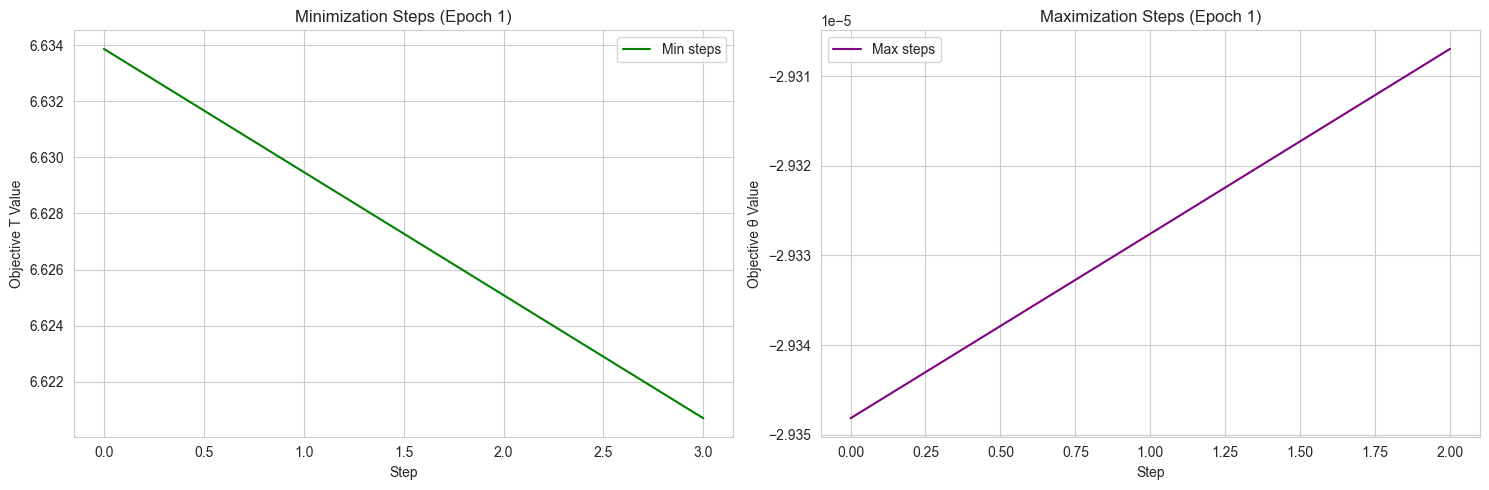

 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
step 1 of 3 value of Sigma_L: tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<MmBackward0>) after projection to Gelbrich ball
norm decrease at Sigma_L
norm decrease at Sigma_L
norm de

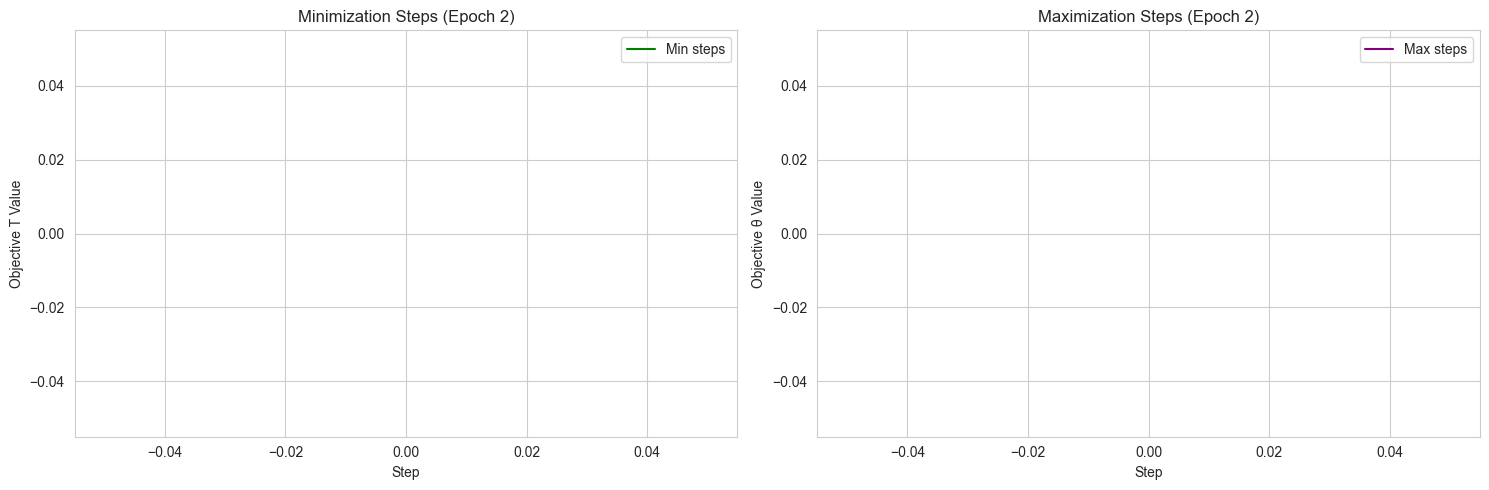

 20%|██        | 2/10 [00:04<00:19,  2.42s/it]

Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_L
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
norm decrease at Sigma_H
step 1 of 3 value of Sigma_L: tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<MmBackward0>) after projection to Gelbrich ball
norm decrease at Sigma_L


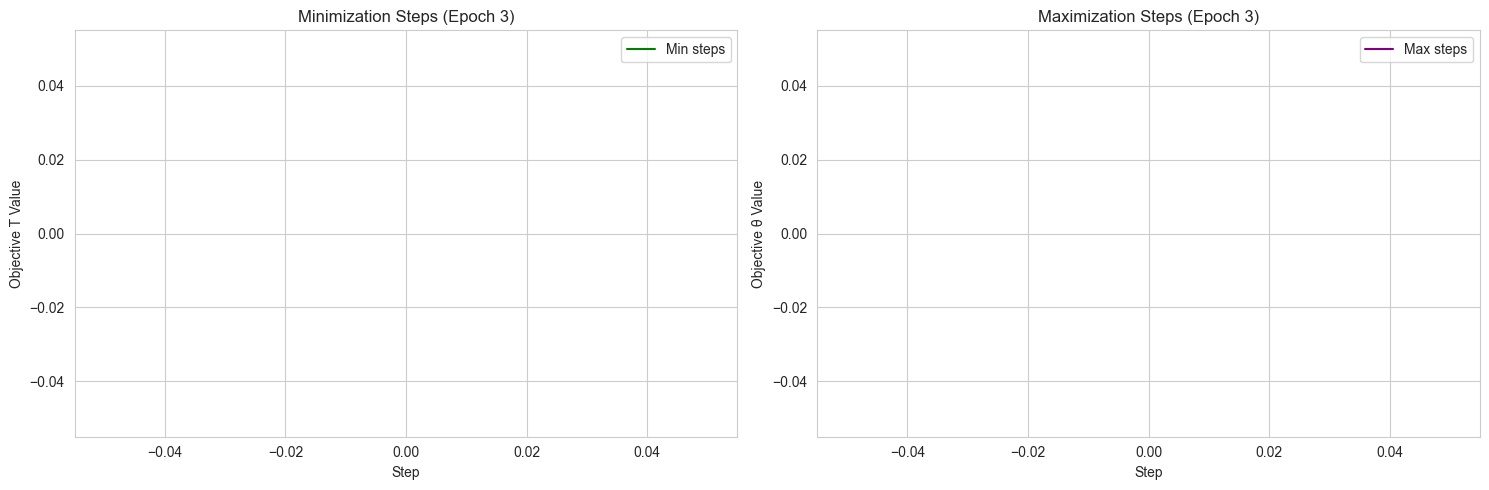

 30%|███       | 3/10 [00:20<00:59,  8.56s/it]

Gradient contains NaN!
step:  1
Gradient contains NaN!
step:  2
Gradient contains NaN!
step:  3
Gradient contains NaN!
step:  4


 30%|███       | 3/10 [00:28<01:07,  9.64s/it]


KeyboardInterrupt: 

In [31]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': 2,
                    'delta': 3,
                    'lambda_L': 0.9,
                    'lambda_H': 0.9,
                    'lambda_param': 3,
                    'eta_max': 0.0001,
                    'eta_min': 0.0001,
                    'max_iter': 10,
                    'num_steps_min': 4,
                    'num_steps_max': 3,
                    'tol': 1e-8,
                    'seed': seed,
                    'robust_L': True,
                    'robust_H': True,
                    'plot_steps': True,
                    'plot_epochs': False,
                    'display_results': True
                }

params_Lerica, params_Herica, T_erica, inobjs, epobjs = run_optimization(**params_erica)

## Isolate min and max objectives


In [32]:
def plot_overall_progress(objectives_list, robust=False):
    """
    Plot objective values over epochs from a simple list.
    
    Args:
        objectives_list: List of objective values per epoch
        robust: Boolean flag (not used in this simplified version)
    """
    plt.figure(figsize=(10, 6))
    
    # Create x-axis values (epoch numbers)
    epochs = range(1, len(objectives_list) + 1)
    
    # Plot the objectives
    sns.lineplot(
        x=epochs,
        y=objectives_list,
        color='blue',
        label='Objective'
    )
    
    plt.title('Optimization Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Objective Value')
    plt.grid(True, alpha=0.3)
    
    # Add markers to better see individual points
    plt.scatter(epochs, objectives_list, color='blue', alpha=0.5, s=30)
    
    # Scientific notation for y-axis if values are very small/large
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()

### Theta Maximization (works)

In [33]:
def run_theta_optimization_max(theta_hatL, theta_hatH, initial_theta,
                                epsilon, delta, lambda_L, lambda_H, lambda_param, 
                                eta_min, eta_max, max_iter, num_steps_min, num_steps_max,
                                tol, seed, robust, plot_steps, plot_epochs, display_results):
                
    # Start timing
    start_time = time.time()

    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)

    hat_mu_L, hat_Sigma_L = torch.from_numpy(theta_hatL['mu_U']).float(), torch.from_numpy(theta_hatL['Sigma_U']).float()
    hat_mu_H, hat_Sigma_H = torch.from_numpy(theta_hatH['mu_U']).float(), torch.from_numpy(theta_hatH['Sigma_U']).float()

    l = hat_mu_L.shape[0]
    h = hat_mu_H.shape[0]

    if initial_theta == 'gelbrich':
        # Gelbrich initialization
        ll_moments      = mut.sample_moments_U(mu_hat = theta_hatL['mu_U'], Sigma_hat = theta_hatL['Sigma_U'], bound = epsilon, num_envs = 1)
        mu_L, Sigma_L = ll_moments[0]
        mu_L, Sigma_L = torch.from_numpy(mu_L).float(), torch.from_numpy(Sigma_L).float()

        hl_moments      = mut.sample_moments_U(mu_hat = theta_hatH['mu_U'], Sigma_hat = theta_hatH['Sigma_U'], bound = delta, num_envs = 1)
        mu_H, Sigma_H = hl_moments[0]
        mu_H, Sigma_H = torch.from_numpy(mu_H).float(), torch.from_numpy(Sigma_H).float()

    elif initial_theta == 'empirical':
        mu_L, Sigma_L = hat_mu_L, hat_Sigma_L
        mu_H, Sigma_H = hat_mu_H, hat_Sigma_H

    T = torch.randn(h, l, requires_grad=True)
    
    previous_objective = float('inf')  
    theta_objs = []
    for epoch in tqdm(range(max_iter)): 

        mu_L         = update_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta_max)

        mu_H         = update_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta_max)

        Sigma_L_half = update_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta_max)
        Sigma_L      = update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param)
        
        Sigma_H_half = update_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta_max)
        Sigma_H      = update_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param)

        # Project onto Gelbrich balls
        mu_L, Sigma_L = oput.project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        mu_H, Sigma_H = oput.project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        # Verify constraints
        satisfied_L, dist_L, epsi = oput.verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        satisfied_H, dist_H, delt = oput.verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        if not satisfied_L:
            print(f"Warning: Constraints not satisfied for mu_L and Sigma_L! Distance: {dist_L} and epsilon = {epsi}")

        if not satisfied_H:
            print(f"Warning: Constraints not satisfied for mu_H and Sigma_H! Distance: {dist_H} and delta = {delt}")
        
        obj = 0
        #obj_values = []
        for iota in Ill:
            L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
            H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form())

            obj_value_iota = oput.compute_objective_value(T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H)
            
            obj = obj + obj_value_iota
            #obj_values.append(obj_value_iota)
        
        #obj = torch.mean(torch.tensor(obj_values))
        obj = obj/len(Ill)
        print(f"obj: {obj.item()} at epoch {epoch+1}/{max_iter}")
        theta_objs.append(obj.item())

        # if previous_objective - obj.item() > 0:
        #     print('obj decrease')
        #     break
        # else:
        #     pass
        # Check convergence
        criterion = abs(previous_objective - obj.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {obj.item()}")
            break

        previous_objective = obj.item()


    paramsL = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}

    T = T.detach().numpy()
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    if display_results == True:
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T, theta_objs

In [34]:
def update_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta):

    term1     = torch.zeros_like(mu_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float() 
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float() 

        term1     = term1 + V_i.T @ V_i @ mu_L.float() - V_i.T @ H_i @ mu_H.float()
    
    term2     = 0 #-2 * lambda_L * (mu_L - hat_mu_L)
    grad_mu_L = (2 / (n+1)) * term1 - term2
    
    return mu_L + (eta * grad_mu_L)

def update_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta):

    term1     = torch.zeros_like(mu_H)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()  
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()  

        term1 = term1 + H_i.T @ H_i @ mu_H.float() - (V_i.T @ H_i).T @ mu_L.float()
    
    term2     = 0 #-2 * lambda_H * (mu_H - hat_mu_H)
    grad_mu_H = (2 / (n+1)) * term1 - term2

    return mu_H + (eta * grad_mu_H)


def update_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta):

    term1        = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
        V_i = T @ L_i.float()

        term1 = term1 + V_i.T @ V_i

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    term2        = 0 #-2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)
    grad_Sigma_L = (2 / (n+1)) * term1 - term2
    
    return Sigma_L + eta * grad_Sigma_L

def update_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta):

    term1        = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i   = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
        
        term1 = term1 + H_i.T @ H_i

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    term2        = 0#-2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)
    grad_Sigma_H = (2 / (n+1)) * term1 - term2

    return Sigma_H + eta * grad_Sigma_H

def update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param):

    Sigma_L = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()  
        V_i = oput.regmat(T @ L_i)  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = V_i @ Sigma_L_half @ V_i.T
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V)) 

        norm_before = torch.norm(sqrtm_V_Sigma_V, p='fro')
        norm_after  = torch.norm(oput.prox_operator(sqrtm_V_Sigma_V, lambda_param), p='fro')
        
        # if norm_before - norm_after > 0:
        #     print('norm decrease at Sigma_L')
        # else:
        #     print('norm INCREASE at Sigma_L')

        prox_Sigma_L_half = oput.prox_operator(sqrtm_V_Sigma_V, lambda_param) @ oput.prox_operator(sqrtm_V_Sigma_V, lambda_param).T
        
        #ll_term_a = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half)
        #ll_term_b = oput.regmat(torch.linalg.pinv(V_i).T)
        #ll_term   = ll_term_a @ ll_term_b
        ll_term   = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half) @ oput.regmat(torch.linalg.pinv(V_i).T)

        Sigma_H   = Sigma_H.float()  
        H_Sigma_H = H_i @ Sigma_H @ H_i.T

        hl_term   = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro') 

        Sigma_L = Sigma_L + (ll_term * hl_term)

    Sigma_L_final = (2 / (n+1)) * Sigma_L 
    Sigma_L_final = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

def update_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param):
    Sigma_H = torch.zeros_like(Sigma_H_half)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
        V_i = oput.regmat(T @ L_i.float())
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()

        #H_Sigma_H         = oput.regmat(H_i @ Sigma_H_half @ H_i.T)
        H_Sigma_H         = H_i @ Sigma_H_half @ H_i.T
        sqrtm_H_Sigma_H   = oput.regmat(oput.sqrtm_svd(H_Sigma_H)) 

        #sqrtm_H_Sigma_H   = oput.sqrtm_svd(H_Sigma_H) 
        norm_before = torch.norm(sqrtm_H_Sigma_H, p='fro')
        norm_after = torch.norm(oput.prox_operator(sqrtm_H_Sigma_H, lambda_param), p='fro')
        
        # if norm_before - norm_after > 0:
        #     print('norm decrease at Sigma_H')
        # else:
        #     print('norm INCREASE at Sigma_H')
        prox_Sigma_H_half = oput.prox_operator(sqrtm_H_Sigma_H, lambda_param) @ oput.prox_operator(sqrtm_H_Sigma_H, lambda_param).T
        #hl_term           = torch.inverse(H_i) @ prox_Sigma_H_half @ torch.inverse(H_i).T
        hl_term           = H_i @ prox_Sigma_H_half @ H_i.T
        
        V_Sigma_V = V_i @ Sigma_L @ V_i.T
        ll_term   = torch.norm(oput.sqrtm_svd(oput.regmat(V_Sigma_V)))

        Sigma_H = Sigma_H + (ll_term * hl_term)
    
    Sigma_H_final = (2 / (n+1)) * Sigma_H
    Sigma_H_final = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

  2%|▏         | 2/100 [00:00<00:05, 17.09it/s]


obj: 3.747725248336792 at epoch 1/100
obj: 3.7478904724121094 at epoch 2/100
obj: 3.7478904724121094 at epoch 3/100
Convergence reached at epoch 3 with objective 3.7478904724121094

               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 0.3367  0.1288  0.2345]
 [ 0.2303 -1.1229 -0.1863]]

Condition Number: 2.7909

Low-Level Parameters:
------------------------------
μ_L = [ 0. -0.  0.]
Σ_L = 
[[0.2322 0.     0.    ]
 [0.     0.2293 0.    ]
 [0.     0.     0.2308]]

High-Level Parameters:
------------------------------
μ_H = [-0.0024 -0.0015]
Σ_H = 
[[4.5762 0.    ]
 [0.     0.129 ]]

Optimization time: 0.1219 seconds


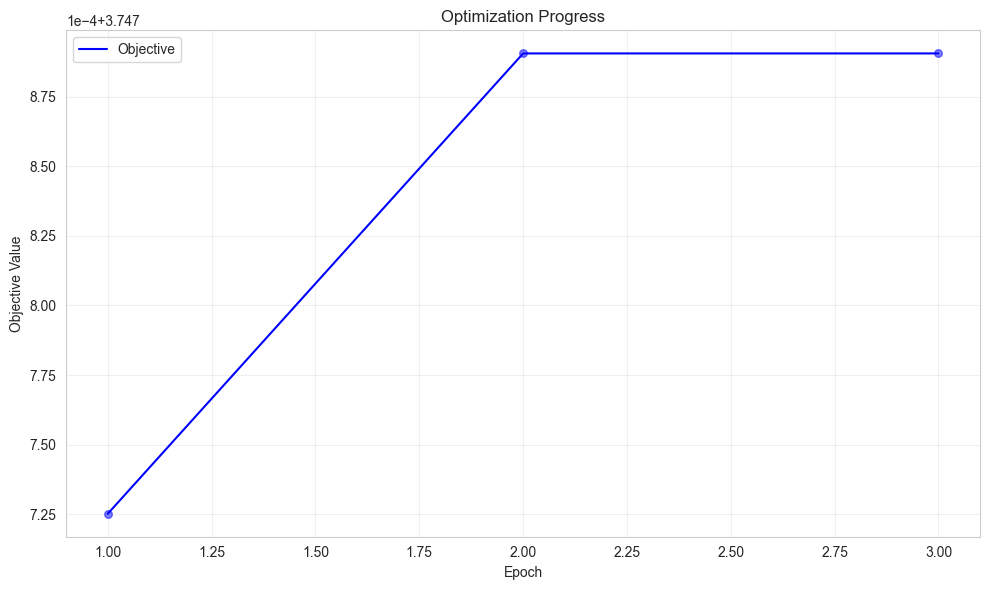

In [36]:
params_max =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': .9,
                    'delta': .8,
                    'lambda_L': 0.9,
                    'lambda_H': 0.9,
                    'lambda_param': 3,
                    'eta_max': 0.0001,
                    'eta_min': 0.0001,
                    'max_iter': 100,
                    'num_steps_min': 4,
                    'num_steps_max': 3,
                    'tol': 1e-6,
                    'seed': seed,
                    'robust': True,
                    'plot_steps': True,
                    'plot_epochs': True,
                    'display_results': True
                }

params_L_max, params_H_max, T_max, objs = run_theta_optimization_max(**params_max)
plot_overall_progress(objs)

### ENRiCO Minimization (works)

In [23]:
def run_enrico_optimization_min(theta_hatL, theta_hatH, initial_theta,
                                epsilon, delta, lambda_L, lambda_H, lambda_param, 
                                eta_min, eta_max, max_iter, num_steps_min, num_steps_max,
                                tol, seed, robust, plot_steps, plot_epochs, display_results):
    
    # Start timing
    start_time = time.time()

    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)

    hat_mu_L, hat_Sigma_L = torch.from_numpy(theta_hatL['mu_U']).float(), torch.from_numpy(theta_hatL['Sigma_U']).float()
    hat_mu_H, hat_Sigma_H = torch.from_numpy(theta_hatH['mu_U']).float(), torch.from_numpy(theta_hatH['Sigma_U']).float()

    if initial_theta == 'gelbrich':
        l = hat_mu_L.shape[0]
        h = hat_mu_H.shape[0]

        # Gelbrich initialization
        ll_moments    = mut.sample_moments_U(mu_hat = theta_hatL['mu_U'], Sigma_hat = theta_hatL['Sigma_U'], bound = epsilon, num_envs = 1)
        mu_L, Sigma_L = ll_moments[0]
        mu_L, Sigma_L = torch.from_numpy(mu_L).float(), torch.from_numpy(Sigma_L).float()

        hl_moments    = mut.sample_moments_U(mu_hat = theta_hatH['mu_U'], Sigma_hat = theta_hatH['Sigma_U'], bound = delta, num_envs = 1)
        mu_H, Sigma_H = hl_moments[0]
        mu_H, Sigma_H = torch.from_numpy(mu_H).float(), torch.from_numpy(Sigma_H).float()

    elif initial_theta == 'empirical':
        mu_L, Sigma_L = hat_mu_L, hat_Sigma_L
        mu_H, Sigma_H = hat_mu_H, hat_Sigma_H
    
    # Initialize storage
    T_objectives = []

    T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    #T = torch.from_numpy(Tau).float()
    #optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
    optimizer_T = torch.optim.SGD([T], lr=eta_min, momentum=0.9)
    previous_objective = float('inf')  
    objective_T        = torch.tensor(0.0)
    for epoch in tqdm(range(max_iter)): 
            
        objective_T_step = torch.tensor(0.0) #torch.tensor(0.0) # Reset objective at the start of each step
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
            
            obj_value_iota = oput.compute_objective_value(T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H)
            
            objective_T_step = objective_T_step + obj_value_iota
        
        objective_T = objective_T_step/(n+1)

        T_objectives.append(objective_T.item())

        if torch.isnan(T).any():
            print("Gradient contains NaN!")
            print('step: ', epoch+1)

        optimizer_T.zero_grad() 
        objective_T.backward(retain_graph=True)
        optimizer_T.step()  

        # Check convergence
        criterion = abs(previous_objective - objective_T.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
            break

        previous_objective = objective_T.item()

    # Plot overall progress
    # if plot_epochs == True:
    #     oput.plot_overall_progress(T_objectives, robust)

    paramsL = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}

    T = T.detach().numpy()
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    if display_results == True:
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T, T_objectives

  9%|▉         | 89/1000 [00:01<00:10, 87.85it/s]


Convergence reached at epoch 90 with objective 0.10681819915771484

               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 1.8522  1.6661  1.1508]
 [ 0.4442 -0.2606  0.0494]]

Condition Number: 5.6066

Low-Level Parameters:
------------------------------
μ_L = [0. 0. 0.]
Σ_L = 
[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]

High-Level Parameters:
------------------------------
μ_H = [0.0163 0.0008]
Σ_H = 
[[13.3758  0.    ]
 [ 0.      0.3048]]

Optimization time: 1.0248 seconds


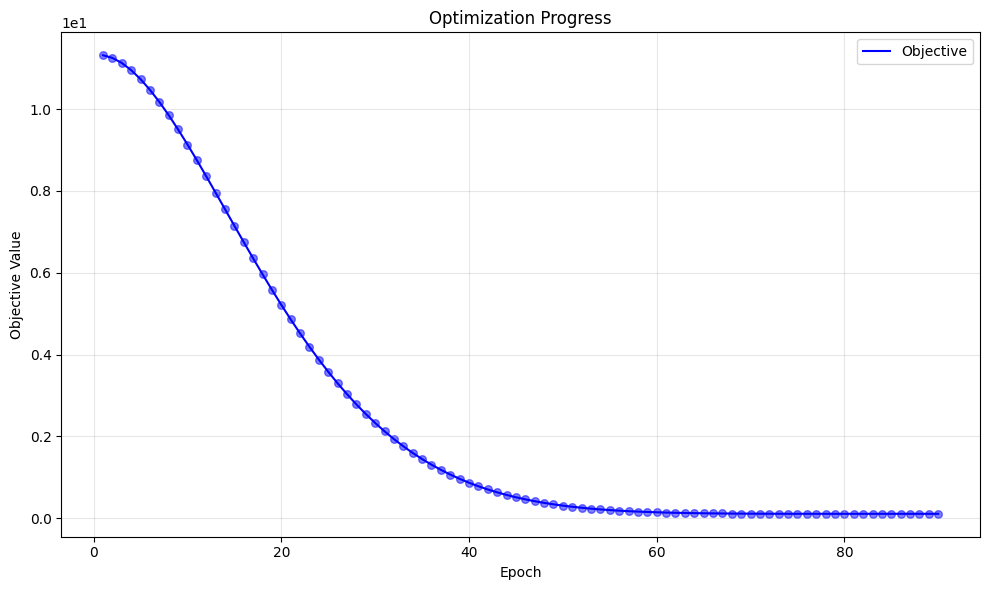

In [24]:
params_enrico_min =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': .9,
                    'delta': .8,
                    'lambda_L': 0.9,
                    'lambda_H': 0.9,
                    'lambda_param': 0.9,
                    'eta_max': 0.001,
                    'eta_min': 0.001,
                    'max_iter': 1000,
                    'num_steps_min': 4,
                    'num_steps_max': 3,
                    'tol': 1e-6,
                    'seed': seed,
                    'robust': True,
                    'plot_steps': True,
                    'plot_epochs': True,
                    'display_results': True
                }

params_Lenrico, params_Henrico, T_enrico, objs = run_enrico_optimization_min(**params_enrico_min)
plot_overall_progress(objs)

### 1. ERICA optimization

  0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: expected scalar type Double but found Float

In [29]:
type_to_params = {
                     'gelbrich_gaussian': {
                           'L': params_Lerica,
                           'H': params_Herica
                     },
                     
                     'boundary_gaussian': {
                           'L': theta_hatL,
                           'H': theta_hatH
                     }
                 }

joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")

### 2. ENRiCO optimization

  0%|          | 0/10 [00:00<?, ?it/s]

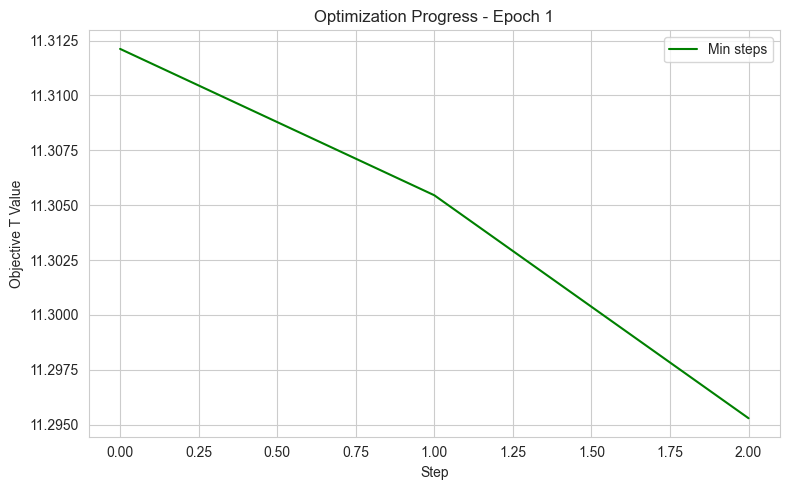

 10%|█         | 1/10 [00:00<00:03,  3.00it/s]

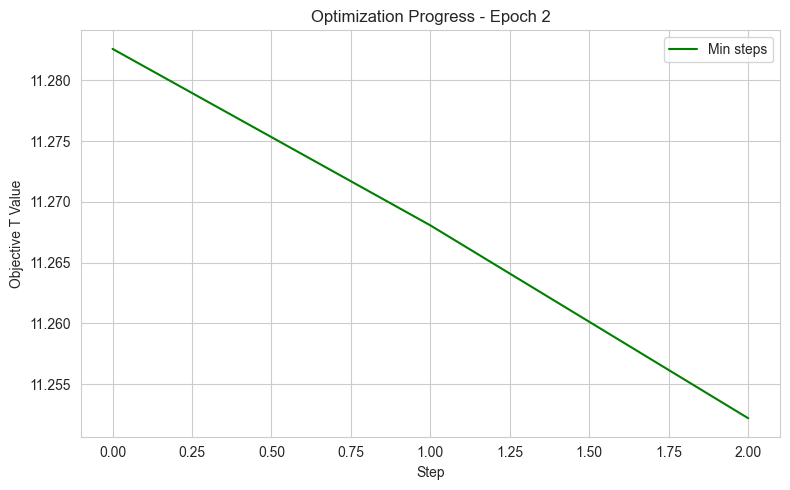

 20%|██        | 2/10 [00:00<00:02,  3.25it/s]

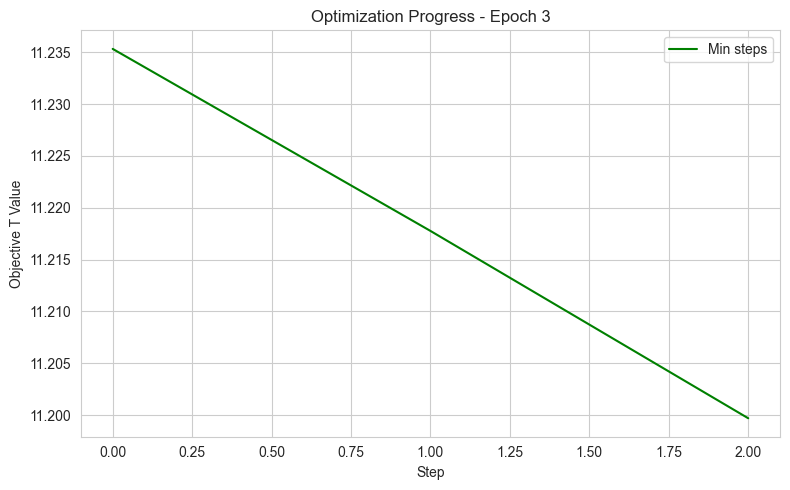

 30%|███       | 3/10 [00:00<00:02,  3.34it/s]

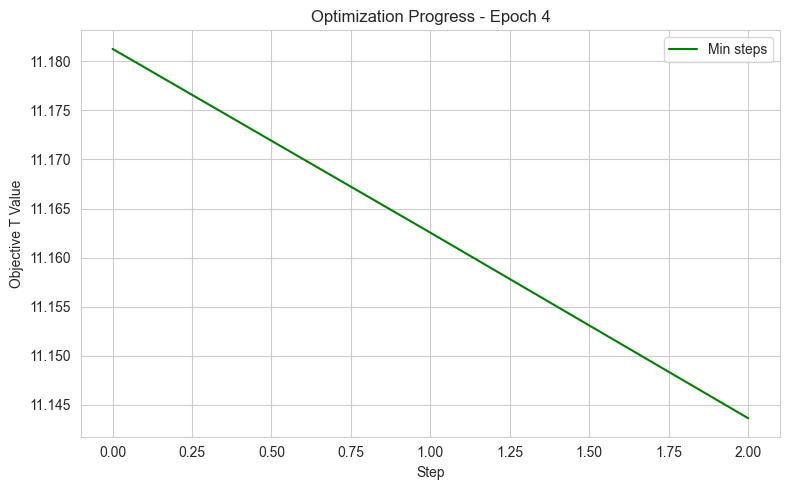

 40%|████      | 4/10 [00:01<00:01,  3.38it/s]

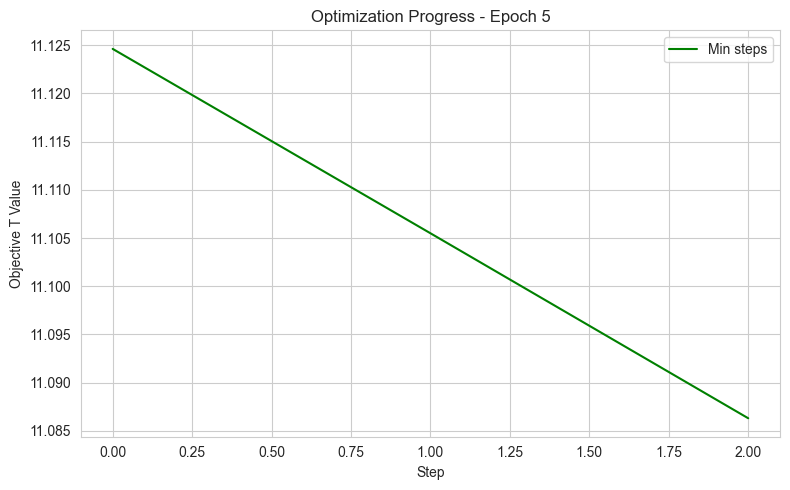

 50%|█████     | 5/10 [00:01<00:01,  3.40it/s]

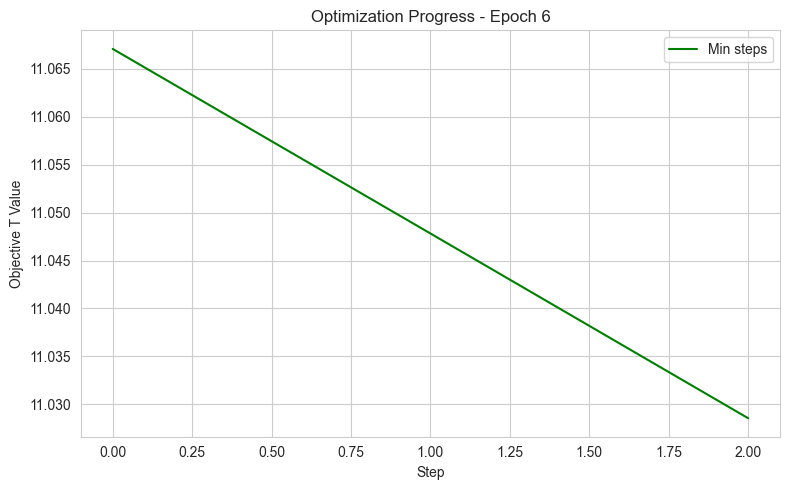

 60%|██████    | 6/10 [00:01<00:01,  3.43it/s]

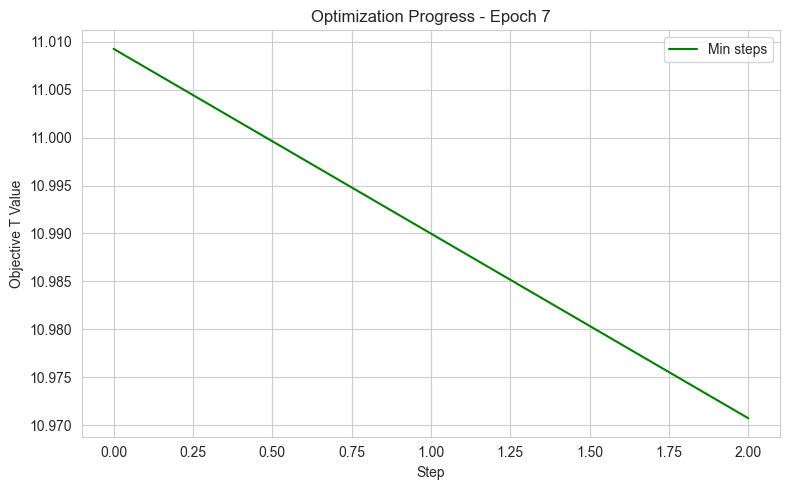

 70%|███████   | 7/10 [00:02<00:00,  3.41it/s]

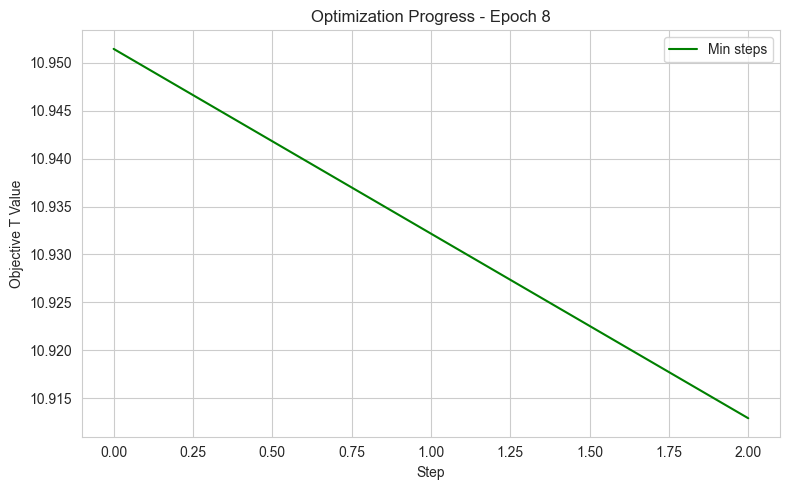

 80%|████████  | 8/10 [00:02<00:00,  3.43it/s]

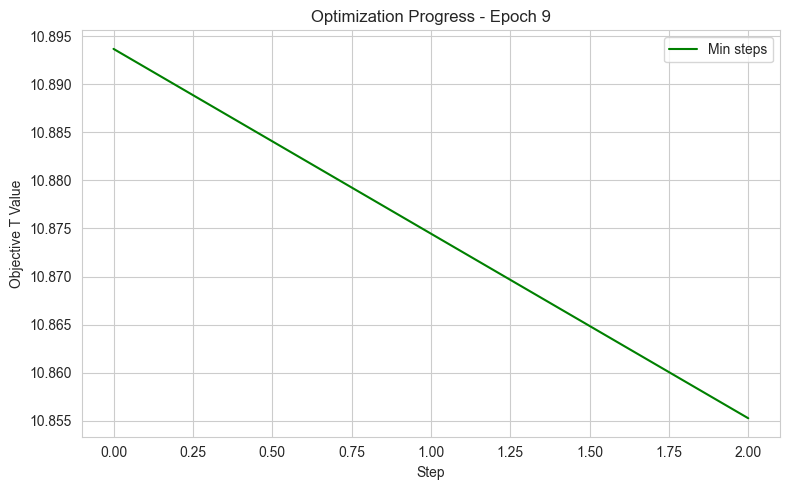

 90%|█████████ | 9/10 [00:02<00:00,  3.43it/s]

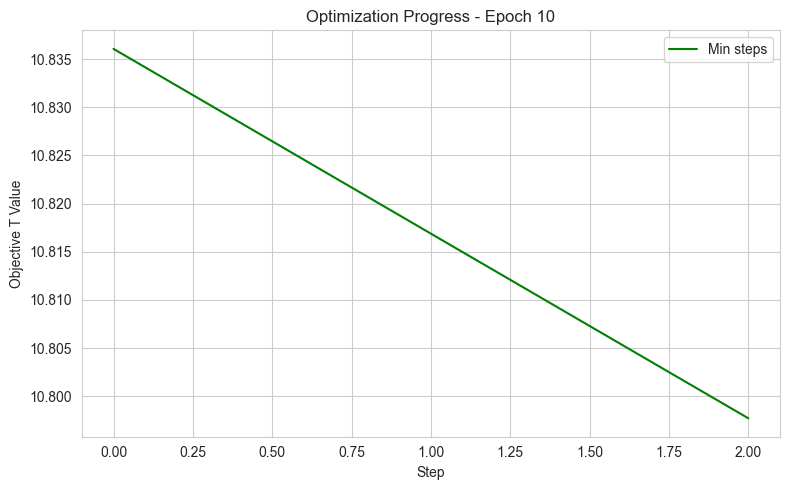

100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


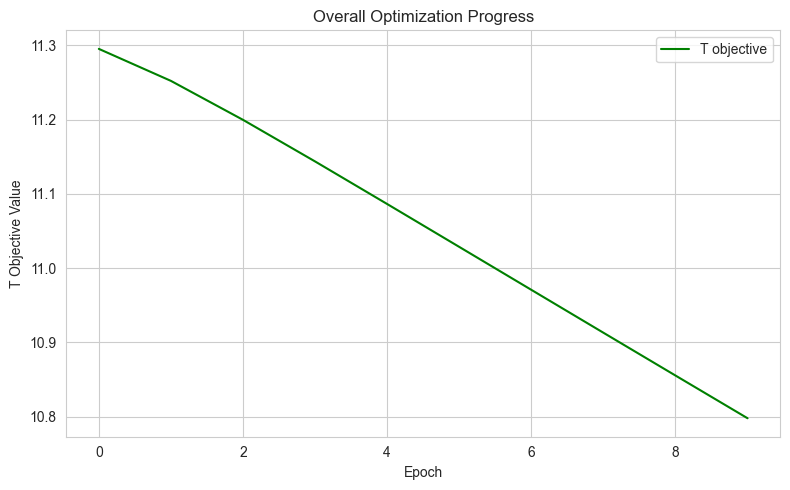


               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 0.3815  0.1573  0.2614]
 [ 0.2347 -1.0976 -0.1802]]

Condition Number: 2.4235

Low-Level Parameters:
------------------------------
μ_L = [0. 0. 0.]
Σ_L = 
[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]

High-Level Parameters:
------------------------------
μ_H = [0.0163 0.0008]
Σ_H = 
[[13.3758  0.    ]
 [ 0.      0.3048]]

Optimization time: 3.1488 seconds


In [100]:
params_enrico =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': 0.9,
                    'delta': 0.8,
                    'lambda_L': 0.9,
                    'lambda_H': 0.9,
                    'lambda_param': 0.9,
                    'eta_max': 0.0001,
                    'eta_min': 0.00001,
                    'max_iter': 10,
                    'num_steps_min': 3,
                    'num_steps_max': 2,
                    'tol': 1e-8,
                    'seed': seed,
                    'robust': False,
                    'plot_steps': True,
                    'plot_epochs': True,
                    'display_results': True
                }

params_Lenrico, params_Henrico, T_enrico, inobjs, epobjs = run_optimization(**params_enrico)

## 3. Barycentric optimization

### a.  Monge

In [101]:
params_bary =  {
                'theta_L': theta_hatL,
                'theta_H': theta_hatH,
                'LLmodels': LLmodels,
                'HLmodels': HLmodels,
                'Ill': Ill,
                'Ihl': Ihl,
                'projection_method': 'svd',
                'initialization': 'avg',
                'autograd': False,
                'seed': seed,
                'max_iter': 100,
                'tol': 1e-6,
                'display_results': True
                }

params_Lbary, params_Hbary, T_bary = barycentric_optimization(**params_bary)


               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[-0.6619 -2.3667 -0.4374]
 [ 0.4381 -0.0869 -0.3231]]

Condition Number: 4.5325

Low-Level Parameters:
------------------------------
μ_L = [0. 0. 0.]
Σ_L = 
[[1.0708 0.3045 0.0299]
 [0.3045 2.0301 0.1995]
 [0.0299 0.1995 1.    ]]

High-Level Parameters:
------------------------------
μ_H = [0.0165 0.0008]
Σ_H = 
[[13.4163  0.1111]
 [ 0.1111  0.3048]]

Optimization time: 0.0805 seconds


### b.  Autograd

In [102]:
params_bary =  {
                'theta_L': theta_hatL,
                'theta_H': theta_hatH,
                'LLmodels': LLmodels,
                'HLmodels': HLmodels,
                'Ill': Ill,
                'Ihl': Ihl,
                'projection_method': 'svd',
                'initialization': 'avg',
                'autograd': True,
                'seed': seed,
                'max_iter': 100,
                'tol': 1e-6,
                'display_results': True
                }

params_Lbary, params_Hbary, T_bary_auto = barycentric_optimization(**params_bary)


               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 0.3467  0.1388  0.2445]
 [ 0.2403 -1.1129 -0.1763]]

Condition Number: 2.6702

Low-Level Parameters:
------------------------------
μ_L = [0. 0. 0.]
Σ_L = 
[[1.0708 0.3045 0.0299]
 [0.3045 2.0301 0.1995]
 [0.0299 0.1995 1.    ]]

High-Level Parameters:
------------------------------
μ_H = [0.0165 0.0008]
Σ_H = 
[[13.4163  0.1111]
 [ 0.1111  0.3048]]

Optimization time: 0.3820 seconds


In [103]:
# # Save results
# np.save('T_erica.npy', T_erica)
# np.save('T_enrico.npy', T_enrico)
# np.save('Tau.npy', Tau)

# # Load results
# T_erica = np.load('T_erica.npy')
# T_enrico = np.load('T_enrico.npy')
# Tau = np.load('Tau.npy')

In [105]:
print('T_erica condition number = ', oput.condition_number(T_erica))
print('T_enrico condition number = ', oput.condition_number(T_enrico))
print('T_bary condition number = ', oput.condition_number(T_bary))
print('T_bary_auto condition number = ', oput.condition_number(T_bary_auto))
print('Ground truth Tau condition number = ', oput.condition_number(Tau))

T_erica condition number =  2.9901102
T_enrico condition number =  2.4235082
T_bary condition number =  4.5325193
T_bary_auto condition number =  2.6702154
Ground truth Tau condition number =  4.738720018687272


## Run Evaluation

In [106]:
data = mut.load_samples(experiment)

In [114]:
add_noiseL         = True
add_noiseH         = True
noise_typeL        = 'boundary_gaussian'
noise_typeH        = 'boundary_gaussian'

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'sinusoidal'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'wass'
num_iter           = 10

In [115]:
def add_random_noise(data, noise_type, level):
   
    n_samples, n_vars = data.shape
    
    if noise_type in ['gelbrich_gaussian', 'boundary_gaussian']:

        params = mut.load_type_to_params(experiment, noise_type, level)

       #params = type_to_params[noise_type][level]
                
    if noise_type == 'gelbrich_gaussian':

        mu_U_hat    = params['mu_U'] #+ np.ones(params_Lerica['mu_U'].shape[0])
        Sigma_U_hat = params['Sigma_U'] #+ np.random.normal(0, 0.1, size=params_Lerica['Sigma_U'].shape)
        radius      = params['radius']

        # Sample moments from Gelbrich ball
        moments = mut.sample_moments_U(
                                        mu_hat=mu_U_hat, 
                                        Sigma_hat=Sigma_U_hat, 
                                        bound=radius, 
                                        num_envs=1
                                        )
        
        noise_mu, noise_Sigma = moments[0]

        noise = np.random.multivariate_normal(
                                                mean=noise_mu, 
                                                cov=noise_Sigma, 
                                                size=n_samples
                                                )

    elif noise_type == 'boundary_gaussian':
        noise_mu, noise_Sigma = params['mu_U'], params['Sigma_U']

        noise = np.random.multivariate_normal(
                                                mean=noise_mu, 
                                                cov=noise_Sigma, 
                                                size=n_samples
                                                )
    
    # Generate noise based on type
    elif noise_type == 'uniform':
        noise = np.random.uniform(low=-1, high=1, size=(n_samples, n_vars))
    
    elif noise_type == 'exponential':
        noise = np.random.exponential(scale=1.0, size=(n_samples, n_vars))
        noise = noise - 1  # Center to mean 0
    
    elif noise_type == 'laplace':
        noise = np.random.laplace(loc=0, scale=1.0, size=(n_samples, n_vars))
    
    elif noise_type == 'chi_square':
        noise = np.random.chisquare(df=1, size=(n_samples, n_vars))
        noise = noise - 1  # Center to mean 0
    
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")
    
    # Normalize noise to have similar scale
    #noise = noise / np.std(noise, axis=0)
    
    return data + noise

In [116]:
T_name = ['T_erica', 'T_enrico', 'T_bary', 'T_bary_auto', 'Ground Truth T']

Average e(τ) for T_erica: 6.73 ± 0.044
Average e(τ) for T_enrico: 22.32 ± 0.027
Average e(τ) for T_bary: 0.86 ± 0.005
Average e(τ) for T_bary_auto: 22.85 ± 0.065
Average e(τ) for Ground Truth T: 1.02 ± 0.005


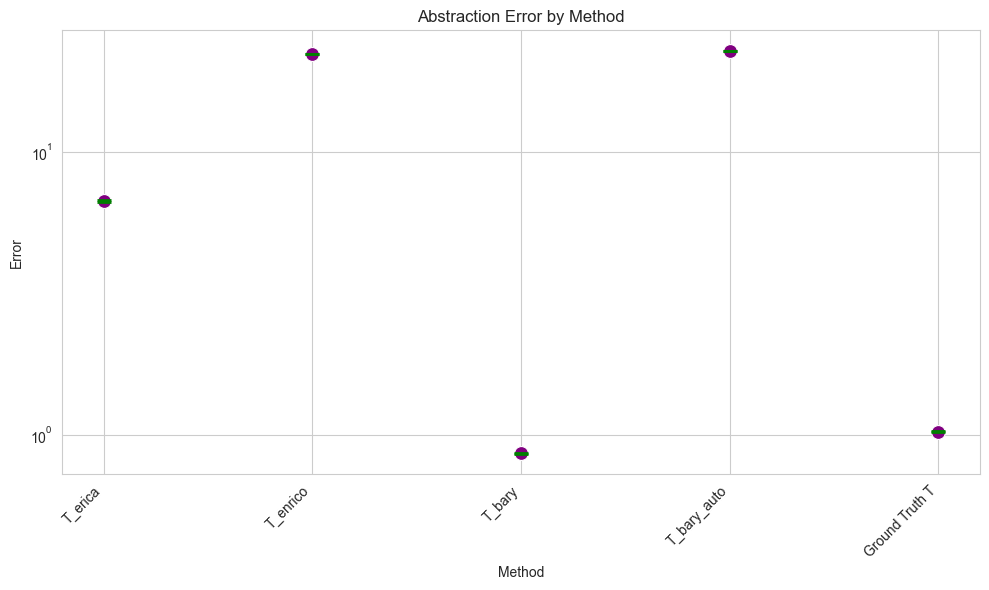

In [117]:
abstraction_error = {}
for i, T in enumerate([T_erica, T_enrico, T_bary, T_bary_auto, Tau]): 
    all_errors = []  
    avg_error = 0
    
    for _ in range(num_iter):
        total = 0
        for iota in Ill:
            base, abst = data[iota]

            if add_noiseL == True:
                base = add_random_noise(base, noise_typeL, 'L')

            if add_noiseH == True:
                abst = add_random_noise(abst, noise_typeH, 'H')

            if lin_contaminationL == True:
                base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)

            if lin_contaminationH == True:
                abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)

            tau_base = base@T.T

            tau_muL    = np.mean(tau_base, axis=0)
            tau_sigmaL = np.cov(tau_base, rowvar=False)
            muH        = np.mean(abst, axis=0)
            sigmaH     = np.cov(abst, rowvar=False)

            if metric == 'wass':
                dist  = mut.compute_wasserstein(tau_muL, tau_sigmaL, muH, sigmaH)
                # tau_gaussian  = mut.sample_distros_Gelbrich([(tau_muL, tau_sigmaL)])[0] 
                # abst_gaussian = mut.sample_distros_Gelbrich([(muH, sigmaH)])[0] 
                # dist = mut.wasserstein_dist(tau_gaussian, abst_gaussian)
            
            elif metric == 'js':
                dist = mut.compute_jensenshannon(tau_base, abst)
            
            #tot_moms += dist 
            total += dist 
            
        iter_avg_ = total/len(Ill)
        all_errors.append(iter_avg_)  
 
    mean_e = np.mean(all_errors)
    std_e = np.std(all_errors)
    abstraction_error[T_name[i]] = (mean_e, std_e*1.96)
    print(f"Average e(τ) for {T_name[i]}: {mean_e:.2f} ± {std_e*1.96:.3f}") 

evut.plot_abstraction_error(abstraction_error)

### Plot Gaussian shift effects

In [33]:
for iota in Ill:
    base, abst = data[iota]
    noisy_base = add_random_noise(base, noise_typeL, 'L')
    evut.plot_distribution_shifts(base, noisy_base)#, f"Base Level Gaussian Shift - {noise_typeL}")
    print( )

### Plot Noise addition and linear contamination effects


In [37]:
for iota in Ill:
    base, abst = data[iota]
    #Add noise
    # base = add_random_noise(base, noise_typeL, 'L')
    # abst = add_random_noise(abst, noise_typeH, 'H')

    #Linear contamination
    base_c = evut.contaminate_linear_relationships(base, contamination_fraction=1, contamination_type='multiplicative')
    #abst_c = evut.contaminate_linear_relationships(abst, contamination_fraction=1, contamination_type='multiplicative')

    evut.plot_contamination_effects(base, base_c)
    print( )


## Structurally generated Gaussians

In [39]:
for i, T in enumerate([T_erica, T_enrico, T_bary, T_bary_auto, Tau]): 
    all_errors = []  
    avg_error = 0
    
    for _ in range(num_iter):
        total = 0
        for iota in Ill:
            L_i = LLmodels[iota]._compute_reduced_form()
            V_i = T @ L_i
            H_i = HLmodels[omega[iota]]._compute_reduced_form()
            muV    = V_i @ params_Lerica['mu_U']
            sigmaV = V_i @ params_Lerica['Sigma_U'] @ V_i.T
            muH    = H_i @ params_Herica['mu_U']
            sigmaH = H_i @ params_Herica['Sigma_U'] @ H_i.T

            dist = mut.compute_wasserstein(muV, sigmaV, muH, sigmaH)

            total += dist

        iter_avg_ = total/len(Ill)
        all_errors.append(iter_avg_)  
 
    mean_e = np.mean(all_errors)
    std_e  = np.std(all_errors)
    print(f"Average e(τ) for {T_name[i]}: {mean_e:.6f} ± {std_e*1.96:.5f}")  

### Run a grid-search

In [41]:
results_dir = f"{experiment}_erica_results"
os.makedirs(results_dir, exist_ok=True)

# Define parameter grids
param_grid = {
    'lambda_param': [0.2, 0.4, 0.6, 0.8, 1.0],
    # Add other hyperparameters here
}

# Fixed parameters
fixed_params = {
    'epsilon': 0.5,
    'delta': 0.5,
    'eta_max': 0.01,
    'eta_min': 0.001,
    'lambda_L': 0.8,
    'lambda_H': 0.8,
    'max_iter': 10,
    'num_steps_min': 1,
    'num_steps_max': 1,
    'tol_max': 1e-4,
    'tol': 1e-4,
    'seed': 42
}

# Generate all combinations of parameters
param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# Iterate over each combination
for idx, params in enumerate(param_combinations, 1):
    try:
        print(f"Running combination {idx}/{len(param_combinations)}: {params}")

        # Run your optimization function here
        final_mu_L, final_Sigma_L, final_mu_H, final_Sigma_H, final_T = optimize_min_max(
                                                                                        mu_L0, Sigma_L0, mu_H0, Sigma_H0,
                                                                                        LLmodels, HLmodels,
                                                                                        hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                        **params,
                                                                                        **fixed_params
                                                                                        )

        # Prepare results
        results = {
            'parameters': params,
            'mu_L': final_mu_L.detach().numpy(),
            'Sigma_L': final_Sigma_L.detach().numpy(),
            'mu_H': final_mu_H.detach().numpy(),
            'Sigma_H': final_Sigma_H.detach().numpy(),
            'T': final_T.detach().numpy(),
            'execution_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        # Save results
        result_filename = f"{results_dir}/result_{idx}.pkl"
        with open(result_filename, 'wb') as f:
            pickle.dump(results, f)

        print(f"Results saved to: {result_filename}")

    except Exception as e:
        print(f"Error with parameters {params}: {str(e)}")
        continue

### Load results

In [46]:
with open('synth1_erica_results/result_5.pkl', 'rb') as f:  # Replace with your actual filename
    loaded_results = pickle.load(f)

# Access specific results
print(f"Parameters used:\n{loaded_results['parameters']}")
print(f"T matrix:\n{loaded_results['T']}")
print(f"Execution time: {loaded_results['execution_time']}")

# Access other components as needed:
# loaded_results['mu_L']
# loaded_results['Sigma_L'] 
# loaded_results['mu_H']
# loaded_results['Sigma_H']

### Compare results

In [33]:
results_dir = "synth1_erica_results"
result_files = [f for f in os.listdir(results_dir) if f.startswith('result_') and f.endswith('.pkl')]

# Load all results into a list
all_results = []
for filename in result_files:
    with open(os.path.join(results_dir, filename), 'rb') as f:
        result = pickle.load(f)
        all_results.append(result)

# Now you can compare results, find the best parameters, etc.
# For example, if you stored objective values:
best_result = min(all_results, key=lambda x: x.get('objective', float('inf')))
print(f"Best parameters: {best_result['parameters']}")

### Find experiments with a specific parameter value

In [39]:
def find_experiments_by_param(results_dir, param_name, param_value):
    # List all result files in the directory
    result_files = [f for f in os.listdir(results_dir) if f.startswith('result_') and f.endswith('.pkl')]
    
    matching_results = []
    
    for filename in result_files:
        with open(os.path.join(results_dir, filename), 'rb') as f:
            result = pickle.load(f)
            # Check if the parameter matches the desired value
            if result['parameters'].get(param_name) == param_value:
                matching_results.append({
                    'filename': filename,
                    'data': result
                })
    
    return matching_results

In [ ]:
# Example usage:
results_dir = "synth1_erica_results"
lambda_param_value = 0.8  # The value you're looking for

matching_experiments = find_experiments_by_param(results_dir, 'lambda_param', lambda_param_value)

if matching_experiments:
    print(f"Found {len(matching_experiments)} experiments with lambda_param = {lambda_param_value}")
    for exp in matching_experiments:
        print(f"\nFilename: {exp['filename']}")
        print(f"Parameters: {exp['data']['parameters']}")
        print(f"Execution time: {exp['data']['execution_time']}")
        # Print other relevant information as needed
        # print(f"T matrix:\n{exp['data']['T']}")
        # print(f"Objective value: {exp['data'].get('objective')}")
else:
    print(f"No experiments found with lambda_param = {lambda_param_value}")

In [76]:
Dhl = torch.from_numpy(Dhl)

TDll = []
for xl in Dll:
    xl = torch.tensor(xl, dtype=torch.float32)

    TDll.append(T @ xl)
TDll = torch.stack(TDll)

# Compute average distance
# Method 1: Using MSE (Mean Squared Error)
mse_distance = torch.mean(torch.sum((TDll - Dhl)**2, dim=1))

# Method 2: Using L2/Euclidean distance
l2_distance = torch.mean(torch.sqrt(torch.sum((TDll - Dhl)**2, dim=1)))

# Method 3: Using L1/Manhattan distance
l1_distance = torch.mean(torch.sum(torch.abs(TDll - Dhl), dim=1))

print(f"MSE Distance: {mse_distance.item()}")
print(f"L2 Distance: {l2_distance.item()}")
print(f"L1 Distance: {l1_distance.item()}")